# UNSUPERVISED LEARNING ON CITY OF SCOTTSDALE CITATIONS
### AGE & TIME OF DAY analysis on five specific citation types, I chose these citations because they had a similar number of citations in the dataset and because they might lend themselves to clustering based on demographics:
    Fail to Yield Turning Left at Intersection
    Fail to Stop at Stop Sign
    DUI-Impaired to Slightest Degree
    Failure to Control Speed to Avoid A Collision
    Exceed Limit By More Than 20mph
  
### Am I able to spot when clusters of specific demographics receive certain types of citations?  To achieve this goal I will:

1. Apply dimensionality reduction techniques to visualize the observations.
1. Apply clustering techniques to group together similar observations.

### Data Source
On a weekly basis the City of Scottsdale Police Department publishes a [dataset](http://data.scottsdaleaz.gov/dataset/police-citations)* which includes one prior years worth citations.  These citations are largely made up of vehicle related infractions such as speeding.  


I downloaded the data in September 2018, September 2019, and January 2020.  In raw format the combined dataset includes just over XXK rows and 22 columns.  For privacy issues, the City of Scottsdale does not release citation data for anyone under 18.  

<br/>

*Contains information from the City of Scottsdale Open Database Portal, which is made available here under the [Open Database License](http://www.scottsdaleaz.gov/AssetFactory.aspx?did=69351).


## DATA PREPROCESSING

In [91]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
pd.set_option('display.max_columns', None)
%matplotlib inline 
sns.set(style='darkgrid')
# plt.style.use('bmh')
plt.rcParams['patch.edgecolor'] = 'none'

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [3]:
# read in csv files
files = glob.glob('data/*.csv')

citations = pd.concat([pd.read_csv(f) \
                      for f in files], sort=True)

In [4]:
# convert column labels to lower case and remove spaces from column names
citations.columns = citations.columns.str.replace(' ', '_')
citations.columns = map(str.lower, citations.columns)

In [7]:
# remove duplicate citations due to overlap in data being downloaded
citations.drop_duplicates('citation_#', inplace=True)

In [8]:
# change data type of age from object to number
citations.cited_person_age = pd.to_numeric(citations.cited_person_age, errors='coerce')

In [9]:
# convert citation date to datetime format
citations['citation_date'] = pd.to_datetime(citations['citation_date'])

# create month column
citations['month'] = citations['citation_date'].dt.month

# create day of week column
citations['day_of_week'] = citations['citation_date'].dt.dayofweek

# create day of week column
citations['week_of_year'] = citations['citation_date'].dt.weekofyear

# extract the hour of the day from the citation time column
citations['hour_of_day'] = citations['citation_time'].apply(lambda x: str(x)[-4:-2])

# replace blanks with 0
# this happened for citations that took place during the hour of 12am
citations.loc[citations.hour_of_day == '', 'hour_of_day'] = 0
# change data type of hour from object to number
citations.hour_of_day = pd.to_numeric(citations.hour_of_day)

In [10]:
# one citation has no age
# drop citations where age isn't provided

citations.dropna(subset=['cited_person_age'], inplace=True)

In [11]:
citations.cited_person_sex.value_counts()

M    35199
F    21220
U       14
Name: cited_person_sex, dtype: int64

In [12]:
# 14 citations have no gender
# drop citations where gender isn't binary
citations.drop(citations[citations.cited_person_sex == 'U'].index, inplace=True)

In [13]:
# verify non-binary genders have been dropped
citations.cited_person_sex.value_counts()

M    35184
F    21216
Name: cited_person_sex, dtype: int64

In [15]:
# how many rows and columns are in the dataset?
citations.shape

(56403, 26)

## DEFINE FEATURES TO PERFORM ANALYSIS ON

In [16]:
# Identify 5 citations that I think will have specific demographics associated with them

citation_groups = [
    'Fail to Yield Turning Left at Intersection',
    'Fail to Stop at Stop Sign',
    'DUI-Impaired to Slightest Degree',
    'Failure to Control Speed to Avoid A Collision',
    'Exceed Limit By More Than 20mph'
]

In [17]:
# subset full citation dataset with only the top 20 citations by count
five_citations = citations[citations.charge_description.isin(citation_groups)]

In [18]:
# how many citations are made up of these 5?
five_citations.shape

(8784, 26)

In [19]:
five_citations.head()

,arizona_statute_code,beat,charge_description,citation_#,citation_date,citation_time,citation_type_code,citation_type_description,cited_person,cited_person_age,cited_person_ethnicity,cited_person_race,cited_person_sex,city,district,officer_badge_#,state,street,street_number,zip,zone,tcmainid,month,day_of_week,week_of_year,hour_of_day
27,28-701A,1.0,Failure to Control Speed to Avoid A Collision,2087778,2019-07-15,1750,CV,Civil Traffic,"Flaaen-Hanna, Lynn",58.0,N,W,F,Scottsdale,D1,1501,AZ,N Hayden Rd / E McKellips Rd,xxx,NaN,103,662835,7,0,29,17
29,28-701.02A2,10.0,Exceed Limit By More Than 20mph,2087820,2019-07-15,1920,CT,Criminal Traffic,"Viadero, Patricio",22.0,N,W,M,Scottsdale,D3,1274,AZ,N Hayden Rd / E Via De Ventura,xxx,NaN,2606,662839,7,0,29,19
31,28-701.02A2,5.0,Exceed Limit By More Than 20mph,2089352,2019-07-15,1927,CT,Criminal Traffic,"Rogers, Sierra",22.0,N,W,F,Scottsdale,D2,1306,AZ,E Indian School Rd,8xxx,NaN,814,662842,7,0,29,19
32,28-701.02A2,1.0,Exceed Limit By More Than 20mph,2084967,2019-07-15,2030,CT,Criminal Traffic,"Sanchez Lopez, JOrge",19.0,H,W,M,Scottsdale,D1,1522,AZ,N Scottsdale Rd / E Skysong Bl,xxx,NaN,301,662845,7,0,29,20
36,28-701A,17.0,Failure to Control Speed to Avoid A Collision,2083769,2019-07-13,1126,CV,Civil Traffic,"Zajac, Rachel",22.0,N,W,F,Scottsdale,D4,1237,AZ,E Frank Lloyd Wright Bl / L101 Frontage Rd Nb,xxx,85260,3404,662851,7,5,28,11


In [20]:
# assign X and y values
X = pd.get_dummies(five_citations[['citation_time', 
                                   'cited_person_sex',
                                  'day_of_week',
                                  'cited_person_age']])

y = five_citations['charge_description'].astype('category').cat.codes

In [21]:
X.head()

,citation_time,day_of_week,cited_person_age,cited_person_sex_F,cited_person_sex_M
27,1750,0,58.0,1,0
29,1920,0,22.0,0,1
31,1927,0,22.0,1,0
32,2030,0,19.0,0,1
36,1126,5,22.0,1,0


In [25]:
y.value_counts()

0    2742
4    2670
2    1469
1    1257
3     646
dtype: int64

## VISUALIZE CLUSTERS

In [22]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### PCA

In [23]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

In [24]:
y.value_counts()

0    2742
4    2670
2    1469
1    1257
3     646
dtype: int64

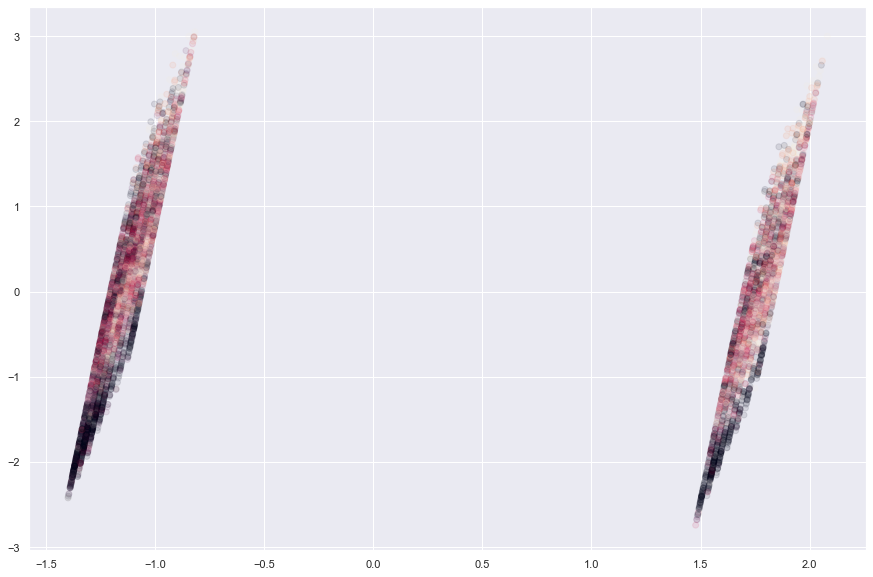

In [92]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=.1)

### t-SNE

In [32]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8784 samples in 0.007s...
[t-SNE] Computed neighbors for 8784 samples in 0.316s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8784
[t-SNE] Computed conditional probabilities for sample 2000 / 8784
[t-SNE] Computed conditional probabilities for sample 3000 / 8784
[t-SNE] Computed conditional probabilities for sample 4000 / 8784
[t-SNE] Computed conditional probabilities for sample 5000 / 8784
[t-SNE] Computed conditional probabilities for sample 6000 / 8784
[t-SNE] Computed conditional probabilities for sample 7000 / 8784
[t-SNE] Computed conditional probabilities for sample 8000 / 8784
[t-SNE] Computed conditional probabilities for sample 8784 / 8784
[t-SNE] Mean sigma: 0.225319
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.296867
[t-SNE] KL divergence after 300 iterations: 1.971857


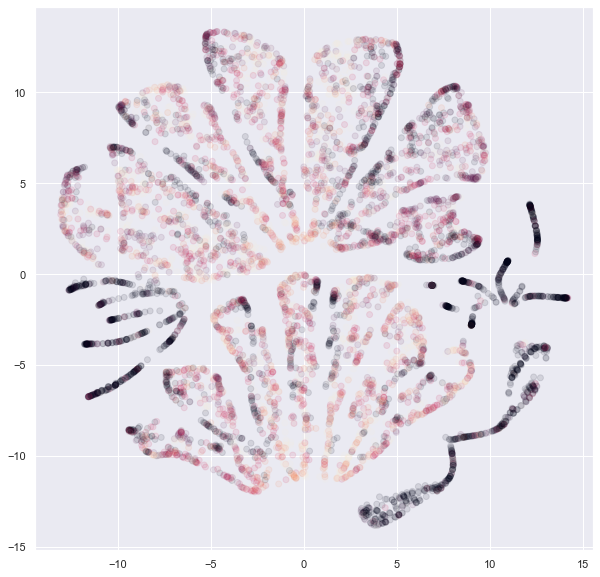

In [34]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.1, c=y)

### UMAP - iteration 1

In [95]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

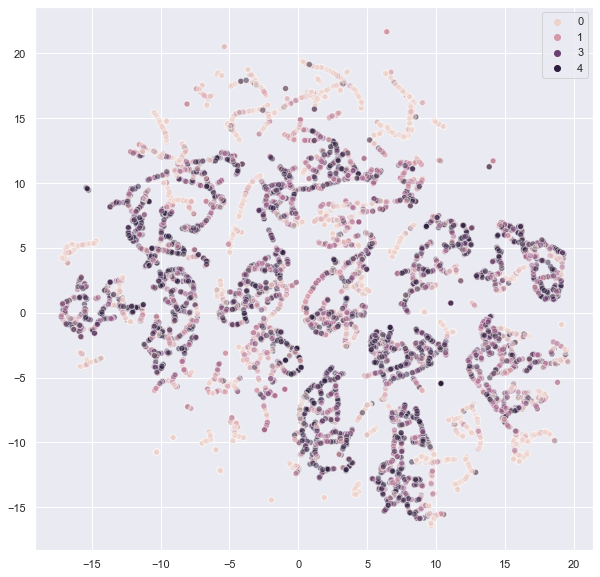

In [96]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=y)
plt.legend(loc='best')

### UMAP - iteration 2

In [97]:
umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_std)

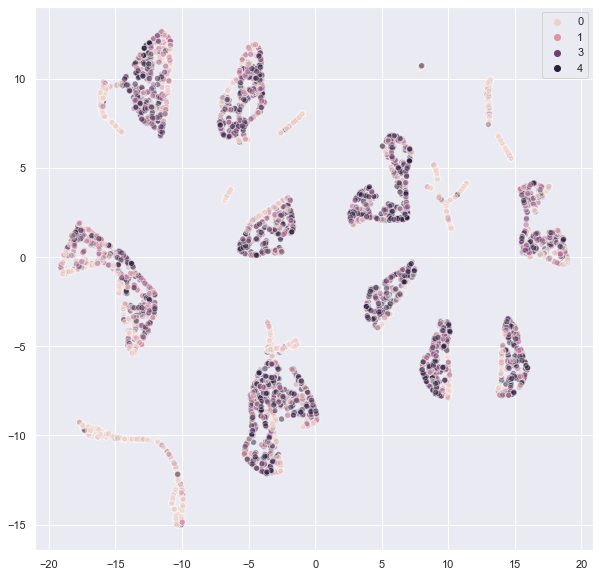

In [98]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=y)
plt.legend(loc='best')

## GROUP CLUSTERS AND EXAMINE FIT OF GROUPINGS

In [38]:
# create df to hold results of each iteration

rows = ['hierarchical - ward',
       'hierarchical - complete',
       'hierarchical - average',
       'k-means',
       'gaussian - full',
       'gaussian - tied',
       'gaussian - diag',
       'gaussian - spherical']

columns = ['ARI',
          'silhouette']

results_df = pd.DataFrame(index=rows,
                         columns=columns)

## K-means

In [39]:
# silhouette
labels = KMeans().fit_predict(X_std)

results_df.loc['k-means', 'silhouette'] = round(metrics.silhouette_score(X_std, labels, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, labels, metric='euclidean'), 3)

0.326

In [40]:
# ARI
y_pred = KMeans().fit_predict(X_std)

results_df.loc['k-means', 'ARI'] = round(metrics.adjusted_rand_score(y, y_pred), 3)
round(metrics.adjusted_rand_score(y, y_pred), 3)

0.036

## Agglomerative methods

### 1. Ward - In general, this method tends to find clusters of similar size

In [41]:
# Defining the agglomerative clustering
# remember, ward only works with Euclidian
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [42]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - ward', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.031

In [43]:
# examine silhouette score
results_df.loc['hierarchical - ward', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.303

### 2. Complete - Clusters tend to be comprised of highly similar observations, making the resulting groups quite compact.

In [44]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [45]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - complete', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.026

In [46]:
# examine silhouette score
results_df.loc['hierarchical - complete', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.281

### 3. Average - it tends to create larger groups than the complete method. Moreover, the clusters can be different sizes and shapes in contrast to the Ward method.

In [47]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [48]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - average', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.028

In [49]:
# examine silhouette score
results_df.loc['hierarchical - average', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.298

## Gausian Mixture Modeling
Explore each covariance_type parameter:

 1. full: This is the default. Each component has its own general covariance matrix.
 1. tied: All components share the same general covariance matrix.
 1. diag: Each component has its own diagonal covariance matrix.
 1. spherical: Each component has its own single variance.

## full

In [50]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [51]:
# Examine ARI and silhouette score
results_df.loc['gaussian - full', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.297

In [52]:
results_df.loc['gaussian - full', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.031

## tied

In [53]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='tied')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [54]:
# Examine ARI and silhouette score
results_df.loc['gaussian - tied', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.317

In [55]:
results_df.loc['gaussian - tied', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.034

## diag

In [56]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='diag')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [57]:
# Examine ARI and silhouette score
results_df.loc['gaussian - diag', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.298

In [58]:
results_df.loc['gaussian - diag', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.03

## spherical

In [59]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='spherical')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [60]:
# Examine ARI and silhouette score
results_df.loc['gaussian - spherical', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.317

In [61]:
results_df.loc['gaussian - spherical', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.026

In [62]:
results_df

,ARI,silhouette
hierarchical - ward,0.031,0.303
hierarchical - complete,0.026,0.281
hierarchical - average,0.028,0.298
k-means,0.036,0.326
gaussian - full,0.031,0.297
gaussian - tied,0.034,0.317
gaussian - diag,0.03,0.298
gaussian - spherical,0.026,0.317


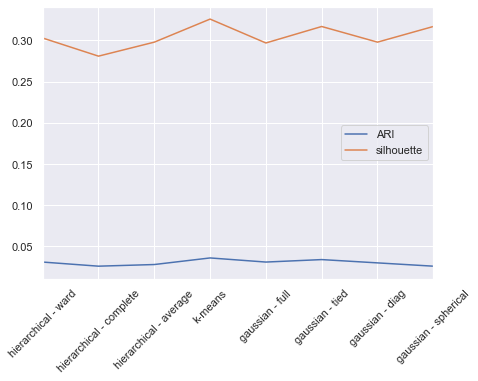

In [63]:
results_df.plot(figsize=(7,5))
plt.xticks(rotation=45);

## k-means 
### iterate over different cluster sizes sice it performed the best above based on silhouette and ARI scores

In [64]:
cluster_number = []
ari_score = []
silhouette_score = []

for i in range(3,21,1):
    cluster_number.append(i)
   
    # Fit model
    y_pred = KMeans(n_clusters=i).fit_predict(X_std)
    
    # generate scores
    ari_score.append(round(metrics.adjusted_rand_score(y, y_pred), 3))
    silhouette_score.append(round(metrics.silhouette_score(X_std, y_pred, metric='euclidean'), 3))

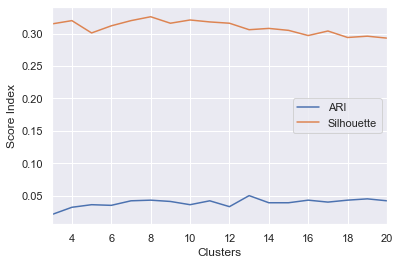

In [69]:
pd.DataFrame(data= {'ARI': ari_score,
                      'Silhouette': silhouette_score},
            index=cluster_number).plot()
plt.ylabel('Score Index')
plt.xlabel('Clusters');

It looks like 8 clusters is the best fit

## Visualize K-means at 8 clusters

In [70]:
labels = KMeans(n_clusters=8).fit_predict(X_std)

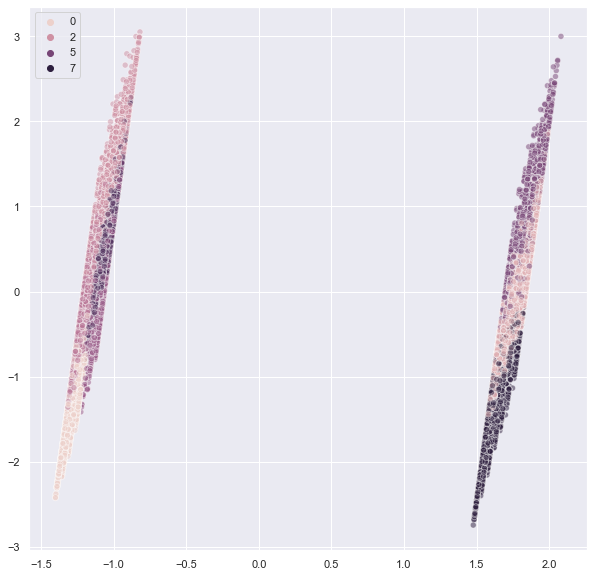

In [87]:
plt.figure(figsize=(10,10))

sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=labels, alpha=.5)

### t-SNE

In [32]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8784 samples in 0.007s...
[t-SNE] Computed neighbors for 8784 samples in 0.316s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8784
[t-SNE] Computed conditional probabilities for sample 2000 / 8784
[t-SNE] Computed conditional probabilities for sample 3000 / 8784
[t-SNE] Computed conditional probabilities for sample 4000 / 8784
[t-SNE] Computed conditional probabilities for sample 5000 / 8784
[t-SNE] Computed conditional probabilities for sample 6000 / 8784
[t-SNE] Computed conditional probabilities for sample 7000 / 8784
[t-SNE] Computed conditional probabilities for sample 8000 / 8784
[t-SNE] Computed conditional probabilities for sample 8784 / 8784
[t-SNE] Mean sigma: 0.225319
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.296867
[t-SNE] KL divergence after 300 iterations: 1.971857


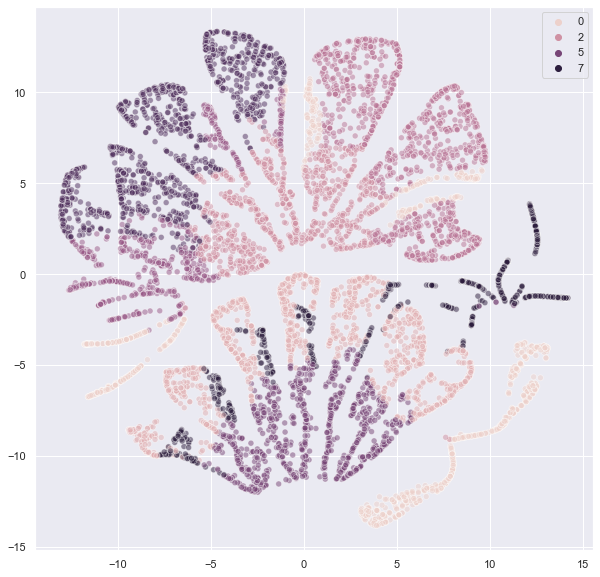

In [76]:
plt.figure(figsize=(10, 10))

sns.scatterplot(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, hue=labels)

### UMAP - iteration 1

In [31]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

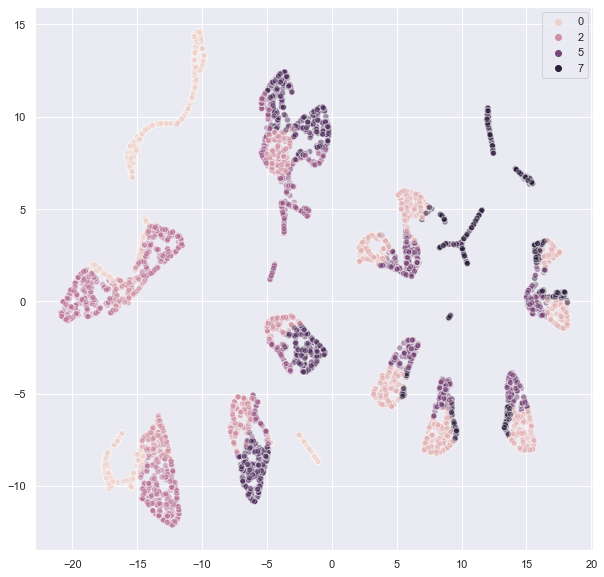

In [77]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=labels)
plt.legend(loc='best')

### UMAP - iteration 2

In [36]:
umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_std)

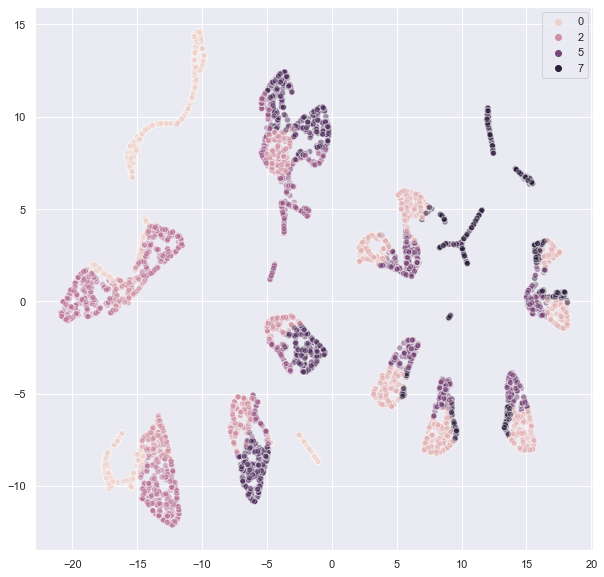

In [78]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=labels)
plt.legend(loc='best')

### UMAP - iteration 3

In [83]:
umap_results = umap.UMAP(n_neighbors=100,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_std)

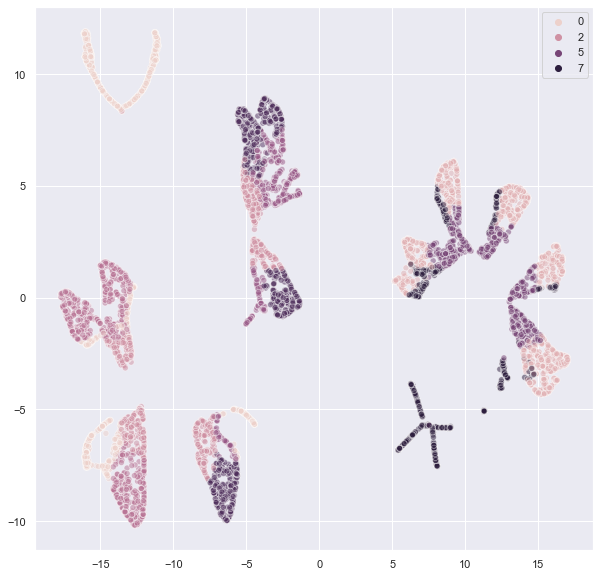

In [84]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=labels)
plt.legend(loc='best')

### UMAP - iteration 4

In [85]:
umap_results = umap.UMAP(n_neighbors=500,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_std)

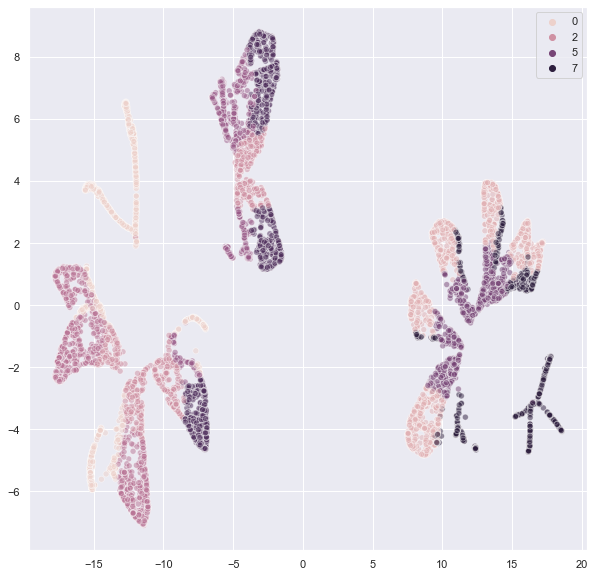

In [86]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=labels)
plt.legend(loc='best')

## Summary:
### The best fitting clustering method was K-means, which generated 8 clusters.  Visually, I am unable to depict the clusters as separate from each other.

### Examine clusters using DBSCAN

In [79]:
# adjust min_samples parameter

min_samples = []
cluster_count_min_samples = []

for i in range(1,1001,100):
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=1, min_samples=i)
    min_samples.append(i)
    
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    cluster_count_min_samples.append(len(set(clusters)) - (1 if -1 in clusters else 0))
    
cluster_count_min_samples

[2, 2, 2, 2, 2, 2, 2, 2, 1, 1]

In [80]:
# adjust eps parameter

eps = []
cluster_count_eps = []

for i in range(1,1001,100):
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=i, min_samples=1)
    eps.append(i)
    
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    cluster_count_eps.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
cluster_count_eps

[2, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [81]:
# combine results
pd.DataFrame(data= {'min_samples': cluster_count_min_samples,
                      'eps': cluster_count_eps},
            index=range(1,11,1))

,min_samples,eps
1,2,2
2,2,1
3,2,1
4,2,1
5,2,1
6,2,1
7,2,1
8,2,1
9,1,1
10,1,1


Text(0, 0.5, 'Clusters')

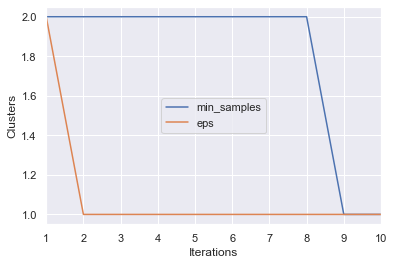

In [82]:
pd.DataFrame(data= {'min_samples': cluster_count_min_samples,
                      'eps': cluster_count_eps},
            index=range(1,11,1)).plot()
plt.xlabel('Iterations')
plt.ylabel('Clusters')